In [ ]:
#One should run this in google colab if amd gpu's cant run it. Simply create a new Google Colab notebook and upload this file.

In [2]:
import pickle
with open ('train_x.ob', 'rb') as fp:
  train_x = pickle.load(fp)
with open ('val_x.ob', 'rb') as fp:
  val_x = pickle.load(fp)
with open ('test_x.ob', 'rb') as fp:
  test_x = pickle.load(fp)
with open ('train_y.ob', 'rb') as fp:
  train_y = pickle.load(fp)
with open ('val_y.ob', 'rb') as fp:
  val_y = pickle.load(fp)
with open ('test_y.ob', 'rb') as fp:
  test_y = pickle.load(fp)

In [3]:
print(len(train_x))
print(len(train_y))

print(len(val_x))
print(len(val_y))

print(len(test_x))
print(len(test_y))
print(train_x.shape)

246
246
52
52
52
52
(246, 15000, 1)


In [4]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras.preprocessing import sequence
from sklearn import utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
import matplotlib.pyplot as plt



In [5]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.ReLU()(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.BatchNormalization()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.BatchNormalization()(conv3)

    output_layer1 = keras.layers.GlobalAveragePooling1D()(conv3)

    # output_layer1 = keras.layers.Dense(64, activation="relu")(gap)
    output_layer2 = keras.layers.Dense(32, activation="relu")(output_layer1)
    output_layer3 = keras.layers.Dense(16, activation="relu")(output_layer2)
    output_layer3a = keras.layers.Dense(8, activation="relu")(output_layer3)
    output_layer4 = keras.layers.Dense(1, activation="sigmoid")(output_layer3a)

    return keras.models.Model(inputs=input_layer, outputs=output_layer4)

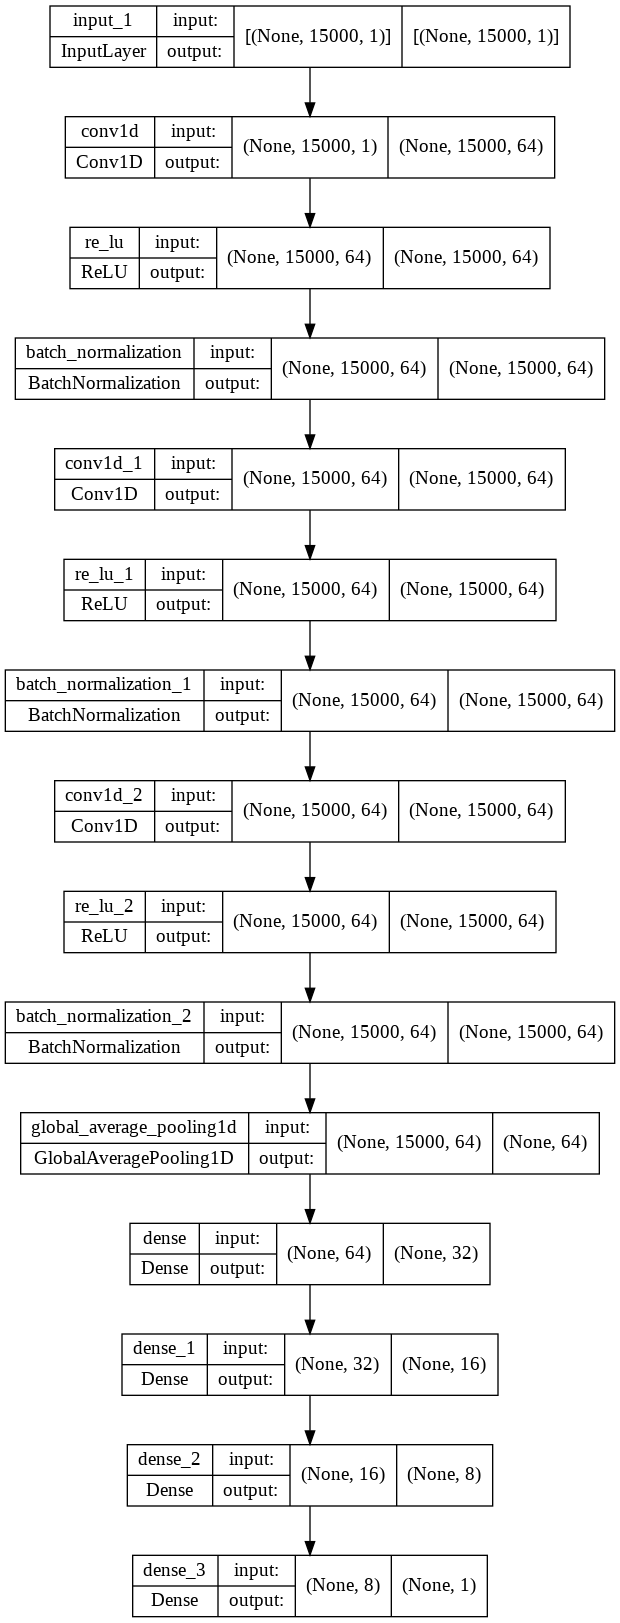

In [7]:
model2 = make_model(input_shape=train_x.shape[1:])
keras.utils.plot_model(model2, show_shapes=True)


In [8]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ModelCheckpoint(
        "best_model_precision.h5", save_best_only=True, monitor="val_precision_m"
    ),
    keras.callbacks.ModelCheckpoint(
        "best_model_accuracy.h5", save_best_only=True, monitor="val_binary_accuracy"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
]
opt = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='binary_crossentropy', optimizer=opt,metrics=['binary_accuracy',f1_m,precision_m, recall_m])

history = model2.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(val_x, val_y),
    verbose=1
)

Epoch 1/500
8/8 [==============================] - 34s 4s/step - loss: 0.7039 - binary_accuracy: 0.4837 - f1_m: 0.4351 - precision_m: 0.4784 - recall_m: 0.4466 - val_loss: 0.6908 - val_binary_accuracy: 0.6538 - val_f1_m: 0.6329 - val_precision_m: 0.6333 - val_recall_m: 0.6515 - lr: 0.0010
Epoch 2/500
8/8 [==============================] - 29s 4s/step - loss: 0.6648 - binary_accuracy: 0.6057 - f1_m: 0.5666 - precision_m: 0.5934 - recall_m: 0.5544 - val_loss: 0.6870 - val_binary_accuracy: 0.6923 - val_f1_m: 0.6553 - val_precision_m: 0.6692 - val_recall_m: 0.6515 - lr: 0.0010
Epoch 3/500
8/8 [==============================] - 31s 4s/step - loss: 0.6565 - binary_accuracy: 0.6098 - f1_m: 0.6075 - precision_m: 0.5971 - recall_m: 0.6243 - val_loss: 0.6842 - val_binary_accuracy: 0.6923 - val_f1_m: 0.6553 - val_precision_m: 0.6692 - val_recall_m: 0.6515 - lr: 0.0010
Epoch 4/500
8/8 [==============================] - 29s 4s/step - loss: 0.6454 - binary_accuracy: 0.6504 - f1_m: 0.6515 - precision

In [9]:
loss, accuracy, f1_score, precision, recall = model2.evaluate(test_x, test_y, verbose=1)


2/2 [==============================] - 1s 508ms/step - loss: 0.4906 - binary_accuracy: 0.7500 - f1_m: 0.8313 - precision_m: 0.7981 - recall_m: 0.8674


In [19]:
model2.save("/content/current_model2.h5")

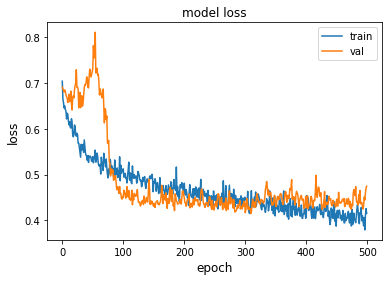

In [10]:
metric = "loss"

plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

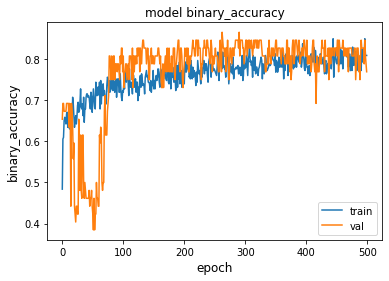

In [11]:
metric = "binary_accuracy"
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [12]:
dependencies = {
    'f1_m': f1_m,
    'precision_m': precision_m,
    'recall_m': recall_m
}
saved = keras.models.load_model('best_model_precision.h5', custom_objects=dependencies)
loss, accuracy, f1_score, precision, recall = saved.evaluate(test_x, test_y, verbose=2)

2/2 - 2s - loss: 0.5688 - binary_accuracy: 0.6923 - f1_m: 0.7916 - precision_m: 0.7225 - recall_m: 0.8864 - 2s/epoch - 801ms/step


In [13]:
saved2 = keras.models.load_model('best_model2.h5', custom_objects=dependencies)
loss, accuracy, f1_score, precision, recall = saved2.evaluate(test_x, test_y, verbose=2)



2/2 - 2s - loss: 0.5143 - binary_accuracy: 0.6923 - f1_m: 0.7803 - precision_m: 0.7803 - recall_m: 0.7803 - 2s/epoch - 761ms/step


In [14]:
saved3 = keras.models.load_model('best_model_accuracy.h5', custom_objects=dependencies)
loss, accuracy, f1_score, precision, recall = saved3.evaluate(test_x, test_y, verbose=2)



2/2 - 2s - loss: 0.4841 - binary_accuracy: 0.7308 - f1_m: 0.8144 - precision_m: 0.7679 - recall_m: 0.8674 - 2s/epoch - 761ms/step


In [15]:
from google.colab import files
files.download('/content/best_model2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
files.download('/content/current_model2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# model = Sequential()
# model.add(Bidirectional(LSTM(128), input_shape=(15000,1)))
# # model.add(Bidirectional(LSTM(64)))
# model.add(Dense(1, activation='sigmoid'))
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# print(model.summary())

In [17]:
# opt = keras.optimizers.Adam(learning_rate=0.001)
# model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy',f1_m,precision_m, recall_m])
# model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=100, batch_size = 16)

In [18]:
# plt.plot(train_x[0], color='magenta', marker='o',mfc='pink' ) #plot the data
# # plt.xticks(range(0,len(train_x[0])+1, 1)) #set the tick frequency on x-axis

# plt.ylabel('data') #set the label for y axis
# plt.xlabel('index') #set the label for x-axis
# plt.title("Plotting a list") #set the title of the graph
# plt.show() #display the graph